# TLDR
- This notebook aims to predict the Global Horizontal Irradiance (GHI) from measurements of other physical quantities such as temperature and azimuthal angle of the sun's incident rays.
- The dataset contains over 100,000 measurements (training examples) taken at different times.
- Firsly, a linear regression model using one single degree feature (azimuthal angle) is used. It is found that increasing the degree of this polynomial feature improves the performance of the model.
- Learning curves were then used to show that the model is underfitting the data and perhaps more features should be added. It was found that a model using all available features (as single degree polynomials) was more successful than one involving one higher degree polynomial feature.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt#
from datetime import datetime

# Data Preprocessing
## Merging the solar angles and solar intensity datasets into one dataframe

The number of training examples (rows) in the solar angle dataframe and solar intensity dataframe do not match.

However, both datasets contain columns for the date and time of the measurement. These will be used to create datetime columns. The datetime columns of the datasets will then be compared to find all datetime values (rows) that have both solar angle and solar intensity values. All other rows will be dropped.

## Adding datetime column to solar angle dataframe

In [2]:
solar_angle_df = pd.read_csv('solar_angles_dataset.csv')
solar_angle_df

Unnamed: 0 Date (M/D/YYYY) Time (H:MM:SS)  Topocentric zenith angle  \
0                0        1/1/2017        0:00:00                157.863107   
1                1        1/1/2017        0:15:00                160.034217   
2                2        1/1/2017        0:30:00                161.901608   
3                3        1/1/2017        0:45:00                163.360197   
4                4        1/1/2017        1:00:00                164.293788   
...            ...             ...            ...                       ...   
105211      105211        1/1/2020       22:45:00                144.648900   
105212      105212        1/1/2020       23:00:00                147.463622   
105213      105213        1/1/2020       23:15:00                150.216607   
105214      105214        1/1/2020       23:30:00                152.884991   
105215      105215        1/1/2020       23:45:00                155.437324   

        Top. azimuth angle (eastward from N)  \
0                                 308.657327   
1                                 316.136781   
2                                 325.052191   
3                                 335.548911   
4                                 347.499018   
...                                      ...   
105211                            284.820719   
105212                            288.398876   
105213                            292.424007   
105214                            297.022677   
105215                            302.358854   

        Top. azimuth angle (westward from S)    Julian day  
0                                 128.657327  2.457754e+06  
1                                 136.136781  2.457754e+06  
2                                 145.052191  2.457754e+06  
3                                 155.548911  2.457754e+06  
4                                 167.499018  2.457754e+06  
...                                      ...           ...  
105211                            104.820719  2.458850e+06  
105212                            108.398876  2.458850e+06  
105213                            112.424007  2.458850e+06  
105214                            117.022677  2.458850e+06  
105215                            122.358854  2.458850e+06  

[105216 rows x 7 columns]

In [3]:
def get_datetime_object_from_solar_angle_df(solar_angle_df_row_index):
    
    year = int(solar_angle_df.iloc[solar_angle_df_row_index]['Date (M/D/YYYY)'].split('/')[2])
    month = int(solar_angle_df.iloc[solar_angle_df_row_index]['Date (M/D/YYYY)'].split('/')[0])
    day = int(solar_angle_df.iloc[solar_angle_df_row_index]['Date (M/D/YYYY)'].split('/')[1])

    hour = int(solar_angle_df.iloc[solar_angle_df_row_index]['Time (H:MM:SS)'].split(':')[0])
    minute = int(solar_angle_df.iloc[solar_angle_df_row_index]['Time (H:MM:SS)'].split(':')[1])
    second = int(solar_angle_df.iloc[solar_angle_df_row_index]['Time (H:MM:SS)'].split(':')[2])

    return datetime(year=year, month=month, day=day, hour=hour, minute=minute, second=second)

In [4]:
datetime_list = [get_datetime_object_from_solar_angle_df(i) for i in range(solar_angle_df.shape[0])]
solar_angle_df['datetime'] = pd.Series(datetime_list) # creating datetime column
solar_angle_df = solar_angle_df.set_index('datetime') # and making it the index column
solar_angle_df = solar_angle_df.drop(['Date (M/D/YYYY)', 'Time (H:MM:SS)'], axis=1) # these columns no longer necessary 

In [5]:
solar_angle_df

Unnamed: 0  Topocentric zenith angle  \
datetime                                                    
2017-01-01 00:00:00           0                157.863107   
2017-01-01 00:15:00           1                160.034217   
2017-01-01 00:30:00           2                161.901608   
2017-01-01 00:45:00           3                163.360197   
2017-01-01 01:00:00           4                164.293788   
...                         ...                       ...   
2020-01-01 22:45:00      105211                144.648900   
2020-01-01 23:00:00      105212                147.463622   
2020-01-01 23:15:00      105213                150.216607   
2020-01-01 23:30:00      105214                152.884991   
2020-01-01 23:45:00      105215                155.437324   

                     Top. azimuth angle (eastward from N)  \
datetime                                                    
2017-01-01 00:00:00                            308.657327   
2017-01-01 00:15:00                            316.136781   
2017-01-01 00:30:00                            325.052191   
2017-01-01 00:45:00                            335.548911   
2017-01-01 01:00:00                            347.499018   
...                                                   ...   
2020-01-01 22:45:00                            284.820719   
2020-01-01 23:00:00                            288.398876   
2020-01-01 23:15:00                            292.424007   
2020-01-01 23:30:00                            297.022677   
2020-01-01 23:45:00                            302.358854   

                     Top. azimuth angle (westward from S)    Julian day  
datetime                                                                 
2017-01-01 00:00:00                            128.657327  2.457754e+06  
2017-01-01 00:15:00                            136.136781  2.457754e+06  
2017-01-01 00:30:00                            145.052191  2.457754e+06  
2017-01-01 00:45:00                            155.548911  2.457754e+06  
2017-01-01 01:00:00                            167.499018  2.457754e+06  
...                                                   ...           ...  
2020-01-01 22:45:00                            104.820719  2.458850e+06  
2020-01-01 23:00:00                            108.398876  2.458850e+06  
2020-01-01 23:15:00                            112.424007  2.458850e+06  
2020-01-01 23:30:00                            117.022677  2.458850e+06  
2020-01-01 23:45:00                            122.358854  2.458850e+06  

[105216 rows x 5 columns]

## Adding datetime column to solar intensity dataframe

In [6]:
solar_intensity_df = pd.read_csv('2017_2019.csv')

In [7]:
def get_datetime_object_from_solar_intensity_df(solar_intensity_df_row_index):
    
    year = int(solar_intensity_df.iloc[solar_intensity_df_row_index]['Year'])
    month = int(solar_intensity_df.iloc[solar_intensity_df_row_index]['Month'])
    day = int(solar_intensity_df.iloc[solar_intensity_df_row_index]['Day'])

    hour = int(solar_intensity_df.iloc[solar_intensity_df_row_index]['Hour'])
    minute = int(solar_intensity_df.iloc[solar_intensity_df_row_index]['Minute'])
    second = 0

    return datetime(year=year, month=month, day=day, hour=hour, minute=minute, second=second)

In [8]:
datetime_list = [get_datetime_object_from_solar_intensity_df(i) for i in range(solar_intensity_df.shape[0])]
solar_intensity_df['datetime'] = pd.Series(datetime_list)
solar_intensity_df = solar_intensity_df.set_index('datetime')
solar_intensity_df = solar_intensity_df.drop(['Year', 'Month', 'Day', 'Hour', 'Minute'], axis=1)

In [9]:
solar_intensity_df

Temperature  Clearsky DHI  Clearsky DNI  Clearsky GHI  \
datetime                                                                     
2017-01-01 00:00:00         -0.6             0             0             0   
2017-01-01 00:15:00         -0.6             0             0             0   
2017-01-01 00:30:00         -0.6             0             0             0   
2017-01-01 00:45:00         -0.6             0             0             0   
2017-01-01 01:00:00         -0.7             0             0             0   
...                          ...           ...           ...           ...   
2019-12-31 22:45:00          4.0             0             0             0   
2019-12-31 23:00:00          3.9             0             0             0   
2019-12-31 23:15:00          3.9             0             0             0   
2019-12-31 23:30:00          3.9             0             0             0   
2019-12-31 23:45:00          3.9             0             0             0   

                     Dew Point  DHI  DNI  GHI  Relative Humidity  \
datetime                                                           
2017-01-01 00:00:00       -2.6    0    0    0              86.29   
2017-01-01 00:15:00       -2.6    0    0    0              86.29   
2017-01-01 00:30:00       -2.6    0    0    0              86.29   
2017-01-01 00:45:00       -2.7    0    0    0              85.54   
2017-01-01 01:00:00       -2.7    0    0    0              86.17   
...                        ...  ...  ...  ...                ...   
2019-12-31 22:45:00        4.0    0    0    0             100.00   
2019-12-31 23:00:00        3.9    0    0    0             100.00   
2019-12-31 23:15:00        3.9    0    0    0             100.00   
2019-12-31 23:30:00        3.9    0    0    0             100.00   
2019-12-31 23:45:00        3.9    0    0    0             100.00   

                     Solar Zenith Angle  Surface Albedo  Pressure  Wind Speed  \
datetime                                                                        
2017-01-01 00:00:00              152.92            0.12      1003         1.7   
2017-01-01 00:15:00              150.22            0.12      1003         1.7   
2017-01-01 00:30:00              147.43            0.12      1003         1.7   
2017-01-01 00:45:00              144.60            0.12      1003         1.6   
2017-01-01 01:00:00              141.71            0.12      1003         1.6   
...                                 ...             ...       ...         ...   
2019-12-31 22:45:00              163.63            0.12       999         2.0   
2019-12-31 23:00:00              162.09            0.12       999         2.0   
2019-12-31 23:15:00              160.16            0.12       999         2.0   
2019-12-31 23:30:00              157.93            0.12       999         2.0   
2019-12-31 23:45:00              155.48            0.12       999         2.0   

                     Unnamed: 18  
datetime                          
2017-01-01 00:00:00          NaN  
2017-01-01 00:15:00          NaN  
2017-01-01 00:30:00          NaN  
2017-01-01 00:45:00          NaN  
2017-01-01 01:00:00          NaN  
...                          ...  
2019-12-31 22:45:00          NaN  
2019-12-31 23:00:00          NaN  
2019-12-31 23:15:00          NaN  
2019-12-31 23:30:00          NaN  
2019-12-31 23:45:00          NaN  

[105120 rows x 14 columns]

## Finding the datetime values which are not in both dataframes and dropping them
The solar angle dataframe has 105216 rows while the solar intensity dataframe ahs 105120 rows.

In [10]:
solar_angle_df_datetimes = solar_angle_df.index
solar_intensity_df_datetimes = solar_intensity_df.index

for datetime_value in solar_angle_df_datetimes:
    if datetime_value not in solar_intensity_df_datetimes:
        solar_angle_df = solar_angle_df.drop(datetime_value, axis=0)

In [11]:
solar_angle_df.shape

(105120, 5)

In [12]:
solar_intensity_df.shape

(105120, 14)

## Merging dataframes
Hence, the number of rows of both dataframes are now equal to 105120 so the dataframes can be merged.

In [13]:
df = pd.concat([solar_angle_df, solar_intensity_df], axis=1)

#### Dropping unnecessary columns

In [14]:
df = df.drop(['Unnamed: 0', 'Unnamed: 18', 'Top. azimuth angle (westward from S)', 'Julian day', 'Clearsky DHI', 'Clearsky GHI', 'Clearsky DNI'], axis=1)

In [15]:
df

Topocentric zenith angle  \
datetime                                        
2017-01-01 00:00:00                157.863107   
2017-01-01 00:15:00                160.034217   
2017-01-01 00:30:00                161.901608   
2017-01-01 00:45:00                163.360197   
2017-01-01 01:00:00                164.293788   
...                                       ...   
2019-12-31 22:45:00                144.783756   
2019-12-31 23:00:00                147.598548   
2019-12-31 23:15:00                150.351476   
2019-12-31 23:30:00                153.019537   
2019-12-31 23:45:00                155.571040   

                     Top. azimuth angle (eastward from N)  Temperature  \
datetime                                                                 
2017-01-01 00:00:00                            308.657327         -0.6   
2017-01-01 00:15:00                            316.136781         -0.6   
2017-01-01 00:30:00                            325.052191         -0.6   
2017-01-01 00:45:00                            335.548911         -0.6   
2017-01-01 01:00:00                            347.499018         -0.7   
...                                                   ...          ...   
2019-12-31 22:45:00                            284.815483          4.0   
2019-12-31 23:00:00                            288.399718          3.9   
2019-12-31 23:15:00                            292.434205          3.9   
2019-12-31 23:30:00                            297.047016          3.9   
2019-12-31 23:45:00                            302.404303          3.9   

                     Dew Point  DHI  DNI  GHI  Relative Humidity  \
datetime                                                           
2017-01-01 00:00:00       -2.6    0    0    0              86.29   
2017-01-01 00:15:00       -2.6    0    0    0              86.29   
2017-01-01 00:30:00       -2.6    0    0    0              86.29   
2017-01-01 00:45:00       -2.7    0    0    0              85.54   
2017-01-01 01:00:00       -2.7    0    0    0              86.17   
...                        ...  ...  ...  ...                ...   
2019-12-31 22:45:00        4.0    0    0    0             100.00   
2019-12-31 23:00:00        3.9    0    0    0             100.00   
2019-12-31 23:15:00        3.9    0    0    0             100.00   
2019-12-31 23:30:00        3.9    0    0    0             100.00   
2019-12-31 23:45:00        3.9    0    0    0             100.00   

                     Solar Zenith Angle  Surface Albedo  Pressure  Wind Speed  
datetime                                                                       
2017-01-01 00:00:00              152.92            0.12      1003         1.7  
2017-01-01 00:15:00              150.22            0.12      1003         1.7  
2017-01-01 00:30:00              147.43            0.12      1003         1.7  
2017-01-01 00:45:00              144.60            0.12      1003         1.6  
2017-01-01 01:00:00              141.71            0.12      1003         1.6  
...                                 ...             ...       ...         ...  
2019-12-31 22:45:00              163.63            0.12       999         2.0  
2019-12-31 23:00:00              162.09            0.12       999         2.0  
2019-12-31 23:15:00              160.16            0.12       999         2.0  
2019-12-31 23:30:00              157.93            0.12       999         2.0  
2019-12-31 23:45:00              155.48            0.12       999         2.0  

[105120 rows x 12 columns]

# Data Exploration

### Dependent Variables
- Topocentric zenith angle: angle between the sun's rays and the vertical.
- Top. azimuth angle (eastward from N): Angle between the sun's rays projected to the horizontal and the direction of North.

### Independent Variables
- Diffuse Horizontal Irradiance (DHI): Amount of radiation received per unit area by a surface that does not arrive on a direct path from the sun, but has been scattered by molecules and particles in the atmosphere. It is the illumination that comes from clouds and the blue sky.
- Direct Normal Irradiance (DNI): Amount of solar radiation received per unit area by a surface that is always held normal to the rays that come in a straight line from the direction of the sun at its current position in the sky.
- Global Horizontal Irradiance (GHI): Total solar radiation incident on a horizontal surface. It is the sum of Direct Normal Irradiance (DNI), Diffuse Horizontal Irradiance, and ground-reflected radiation.

## Histograms
These show the distribution of all variables.

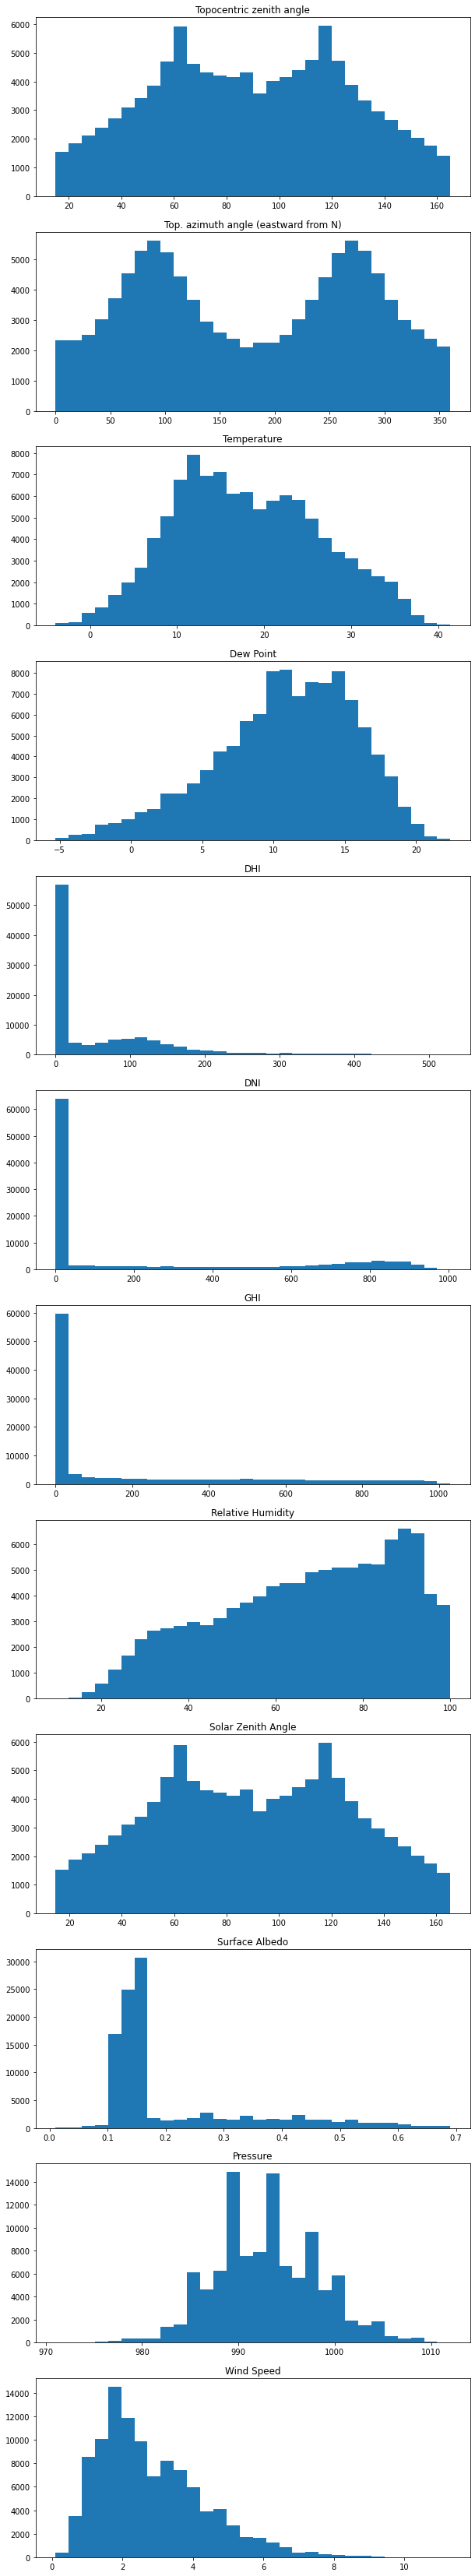

In [16]:
n_cols = df.shape[1]

fig, axs = plt.subplots(n_cols, figsize=(10, 60))

for i in range(n_cols):
    column_name = df.columns[i]
    axs[i].hist(df[column_name], bins=30)
    axs[i].set_title(column_name)

## Plotting all independent variables against all dependent variables
There is a row for each dependent variable

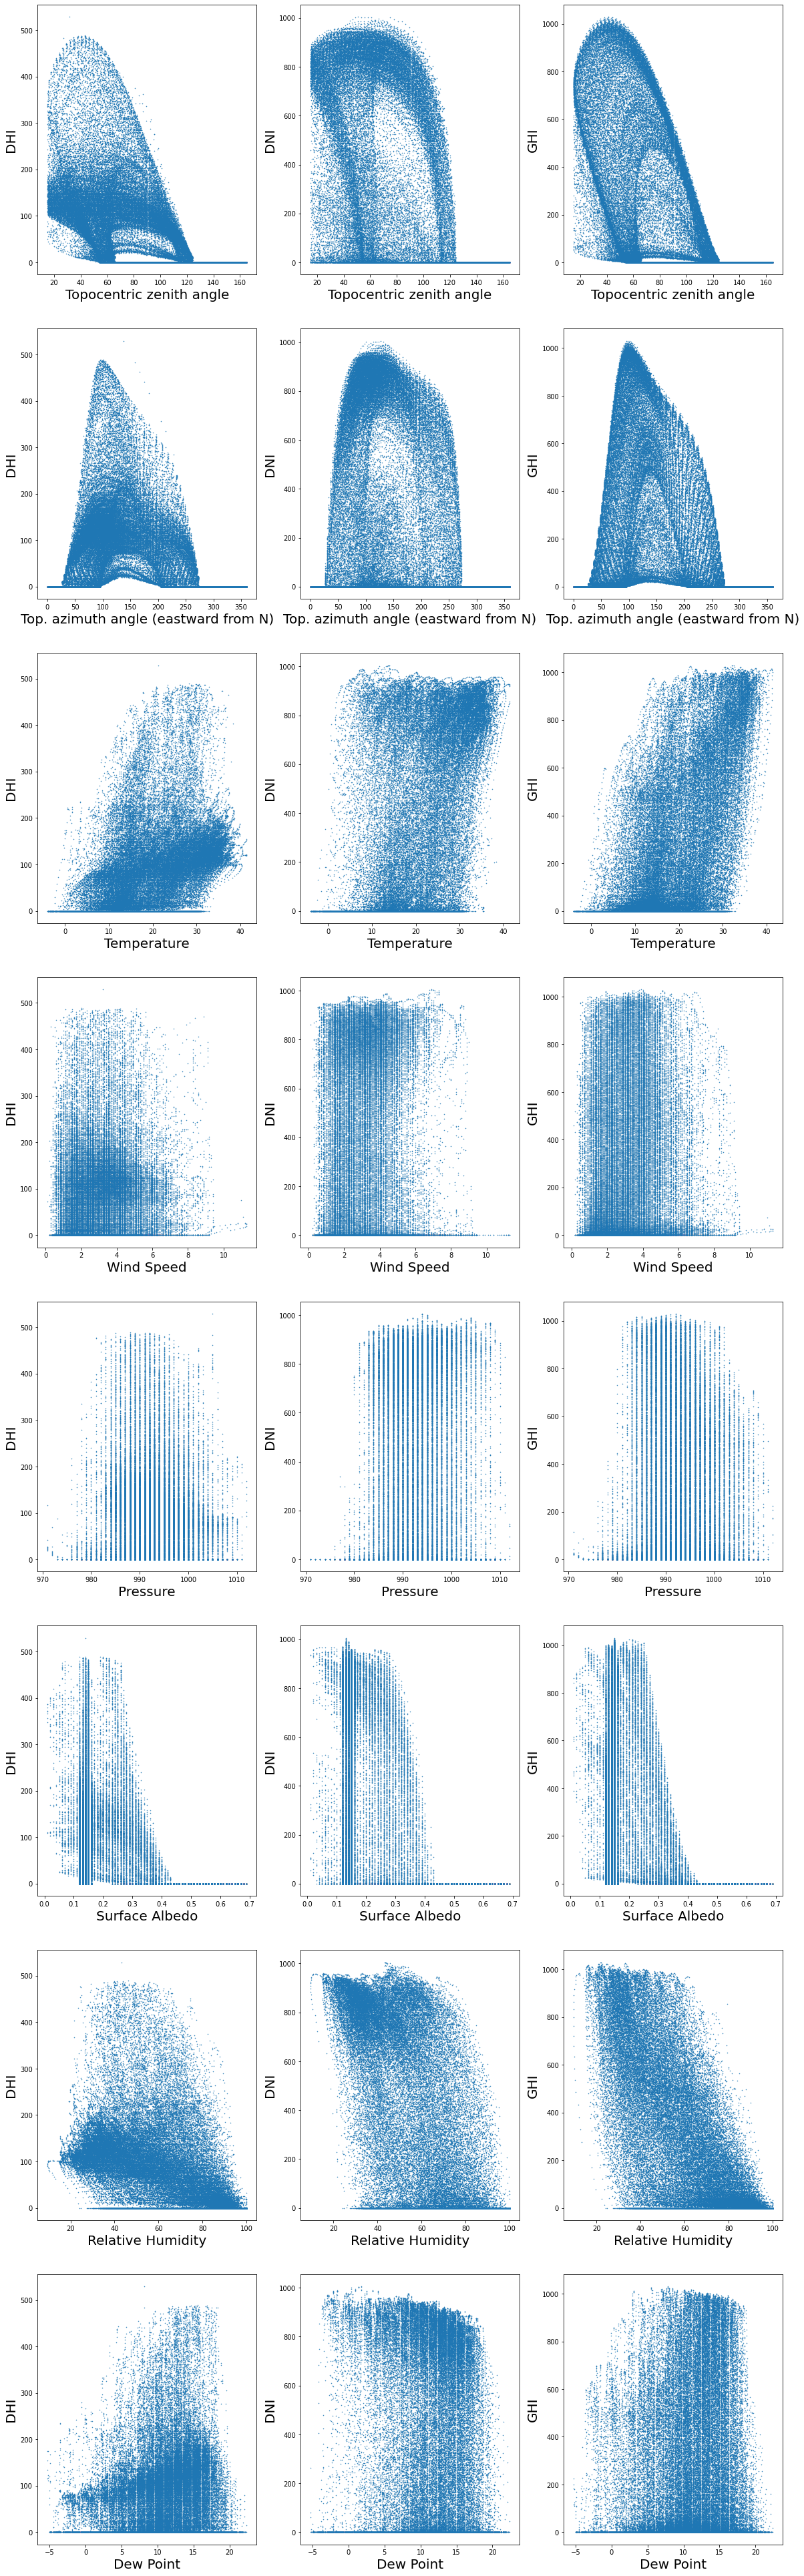

In [17]:
dependent_variables = ['Topocentric zenith angle', 'Top. azimuth angle (eastward from N)', 'Temperature', 'Wind Speed', 'Pressure', 'Surface Albedo', 'Relative Humidity', 'Dew Point']
independent_variables = ['DHI', 'DNI', 'GHI']

fig, axs = plt.subplots(len(dependent_variables), len(independent_variables), figsize=(20, 70))

row = 1
col = 1

for i in range(len(dependent_variables)):
    for j in range(len(independent_variables)):
        
        x = df[dependent_variables[i]]
        y = df[independent_variables[j]]

        axs[row - 1, col - 1].scatter(x, y, s=0.25)
        axs[row - 1, col - 1].set_xlabel(dependent_variables[i], fontsize=20)
        axs[row - 1, col - 1].set_ylabel(independent_variables[j], fontsize=20)

        if col % len(independent_variables) == 0:
            row += 1
            col = 1
        else:
            col += 1

# Machine Learning Model Production

In [18]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split

A linear regression model is used. Below is the cost function for linear regression.

In [19]:
def linear_regression_cost_function(predicted_y, actual_y):
    cost = 0
    m = len(predicted_y)
    for i in range(m):
        cost += 1 / (2 * m) * (predicted_y[i] - actual_y[i]) ** 2
    return cost

In [20]:
def get_average_relative_error(predicted_y, actual_y):
    return np.sqrt(linear_regression_cost_function(predicted_y, actual_y)) / np.average(actual_y)

In [21]:
df

Topocentric zenith angle  \
datetime                                        
2017-01-01 00:00:00                157.863107   
2017-01-01 00:15:00                160.034217   
2017-01-01 00:30:00                161.901608   
2017-01-01 00:45:00                163.360197   
2017-01-01 01:00:00                164.293788   
...                                       ...   
2019-12-31 22:45:00                144.783756   
2019-12-31 23:00:00                147.598548   
2019-12-31 23:15:00                150.351476   
2019-12-31 23:30:00                153.019537   
2019-12-31 23:45:00                155.571040   

                     Top. azimuth angle (eastward from N)  Temperature  \
datetime                                                                 
2017-01-01 00:00:00                            308.657327         -0.6   
2017-01-01 00:15:00                            316.136781         -0.6   
2017-01-01 00:30:00                            325.052191         -0.6   
2017-01-01 00:45:00                            335.548911         -0.6   
2017-01-01 01:00:00                            347.499018         -0.7   
...                                                   ...          ...   
2019-12-31 22:45:00                            284.815483          4.0   
2019-12-31 23:00:00                            288.399718          3.9   
2019-12-31 23:15:00                            292.434205          3.9   
2019-12-31 23:30:00                            297.047016          3.9   
2019-12-31 23:45:00                            302.404303          3.9   

                     Dew Point  DHI  DNI  GHI  Relative Humidity  \
datetime                                                           
2017-01-01 00:00:00       -2.6    0    0    0              86.29   
2017-01-01 00:15:00       -2.6    0    0    0              86.29   
2017-01-01 00:30:00       -2.6    0    0    0              86.29   
2017-01-01 00:45:00       -2.7    0    0    0              85.54   
2017-01-01 01:00:00       -2.7    0    0    0              86.17   
...                        ...  ...  ...  ...                ...   
2019-12-31 22:45:00        4.0    0    0    0             100.00   
2019-12-31 23:00:00        3.9    0    0    0             100.00   
2019-12-31 23:15:00        3.9    0    0    0             100.00   
2019-12-31 23:30:00        3.9    0    0    0             100.00   
2019-12-31 23:45:00        3.9    0    0    0             100.00   

                     Solar Zenith Angle  Surface Albedo  Pressure  Wind Speed  
datetime                                                                       
2017-01-01 00:00:00              152.92            0.12      1003         1.7  
2017-01-01 00:15:00              150.22            0.12      1003         1.7  
2017-01-01 00:30:00              147.43            0.12      1003         1.7  
2017-01-01 00:45:00              144.60            0.12      1003         1.6  
2017-01-01 01:00:00              141.71            0.12      1003         1.6  
...                                 ...             ...       ...         ...  
2019-12-31 22:45:00              163.63            0.12       999         2.0  
2019-12-31 23:00:00              162.09            0.12       999         2.0  
2019-12-31 23:15:00              160.16            0.12       999         2.0  
2019-12-31 23:30:00              157.93            0.12       999         2.0  
2019-12-31 23:45:00              155.48            0.12       999         2.0  

[105120 rows x 12 columns]

# Estimating the Global Horizonal Irradiance using polynomial features of the top azimuthal angle

In [76]:
x = np.array(df['Top. azimuth angle (eastward from N)']).reshape(-1, 1)
y = df['GHI']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
linear_regression = linear_model.LinearRegression()
model = linear_regression.fit(X_train, y_train)

train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

print_model_metrics(train_predictions, y_train, test_predictions, y_test)

Training error: 36947.08732385475
Test error: 36670.067448172216
Relative error of predictions based on test inputs w.r.t. actual test values: 0.9710762274039914


**Currently, the relative error is 0.97**

# Variation of training and test error with the degree of polynomial of x
The above polynomial of feature x (Top. azimuth angle (eastward from N)) has degree 1. The code below sees if increasing the degree of polynomial reduces the training/test error.

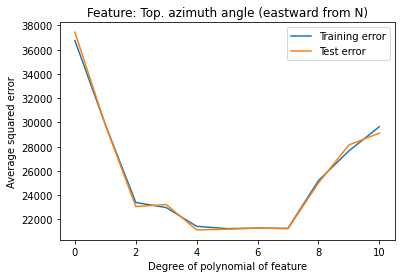

In [48]:
x = df['Top. azimuth angle (eastward from N)']
y = df['GHI']

polynomial_degrees = [i for i in range(11)] # investigating up to 10th degree polynomial

model_parameters = [] # array containing lists of model parameters generated for different degree polynomials
training_costs = [] # list containing training cost for different degree polynomials
test_costs = []

for degree in range(1, 12):
    X = np.array([x ** deg for deg in range(1, degree+1)]).transpose()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    linear_regression = linear_model.LinearRegression()
    model = linear_regression.fit(X_train, y_train)

    parameters = [linear_regression.intercept_]
    for param in linear_regression.coef_:
        parameters.append(param)
    
    model_parameters.append(parameters)

    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)

    training_costs.append(linear_regression_cost_function(train_predictions, y_train))
    test_costs.append(linear_regression_cost_function(test_predictions, y_test))

fig, axs = plt.subplots(1)
axs.plot(polynomial_degrees, training_costs, label='Training error')
axs.plot(polynomial_degrees, test_costs, label='Test error')
axs.set_ylabel('Average squared error')
axs.set_xlabel('Degree of polynomial of feature')
axs.set_title('Feature: Top. azimuth angle (eastward from N)')

axs.legend()
plt.show()

The above graph shows that the degree of polynomial which minimizes the test error is between 3 and 8 (it varies depending on the train-test split)

In [94]:
chosen_degree = test_costs.index(np.min(test_costs))
chosen_parameters = model_parameters[chosen_degree]

x = df['Top. azimuth angle (eastward from N)']
y = df['GHI']

X = np.array([x ** deg for deg in range(1, chosen_degree+1)]).transpose()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
linear_regression = linear_model.LinearRegression()
model = linear_regression.fit(X_train, y_train)

train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

print_model_metrics(train_predictions, y_train, test_predictions, y_test)

Training error: 22950.220595586838
Test error: 23351.904646345905
Relative error of predictions based on test inputs w.r.t. actual test values: 0.7505782965260119


**Therefore, the relative error has decreased from 0.97 (when using a feature of degree 1) to 0.75 (when using a feature of degree 5). Increasing the degree of the feature has improved the model.**

## Plotly polar scatter graph showing predicted GHI with the azimuthal angle as the polynomial feature

In [26]:
def get_predicted_values_from_polynomial_feature(input_features, parameters):
    return [sum([feature_value ** power * parameters[power] for power in range(len(parameters))]) for feature_value in input_features]

In [92]:
import plotly.express as px

dict = {}
dict['Azimuthal Angle'] = np.linspace(0, 360, 20)
dict['Predicted GHI'] = get_predicted_values_from_polynomial_feature(dict['Azimuthal Angle'], chosen_parameters)

df_angle = pd.DataFrame(data=dict)

fig = px.scatter_polar(df_angle, r="Predicted GHI", theta='Azimuthal Angle')
fig.show()

The model predicts that the maximum occurs at an azimuthal angle of around 135 degrees

# Predicted GHI and actual GHI against azimuthal angle

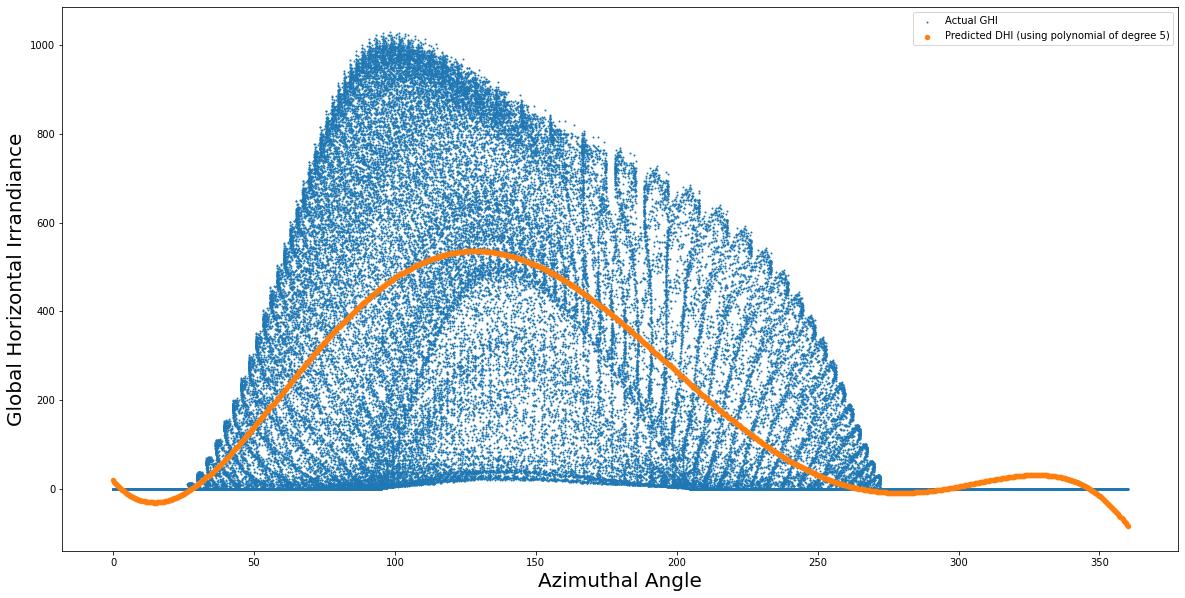

In [95]:
fig, axs = plt.subplots(figsize=(20, 10))
axs.scatter(df['Top. azimuth angle (eastward from N)'], df['GHI'], s=1, label='Actual GHI')

azimuth_angles = np.linspace(0, 360, 1000)
predicted_dhi = get_predicted_values_from_polynomial_feature(azimuth_angles, chosen_parameters)

axs.scatter(azimuth_angles, predicted_dhi, s=20, label=f'Predicted DHI (using polynomial of degree {chosen_degree+1})')
axs.set_ylabel('Global Horizontal Irrandiance', fontsize=20)
axs.set_xlabel('Azimuthal Angle', fontsize=20)
axs.legend()

# Improving the model
Learning curves, i.e. the training and test error against the number of training examples, will are plotted to see if the model is overfitting or underfitting the data. 

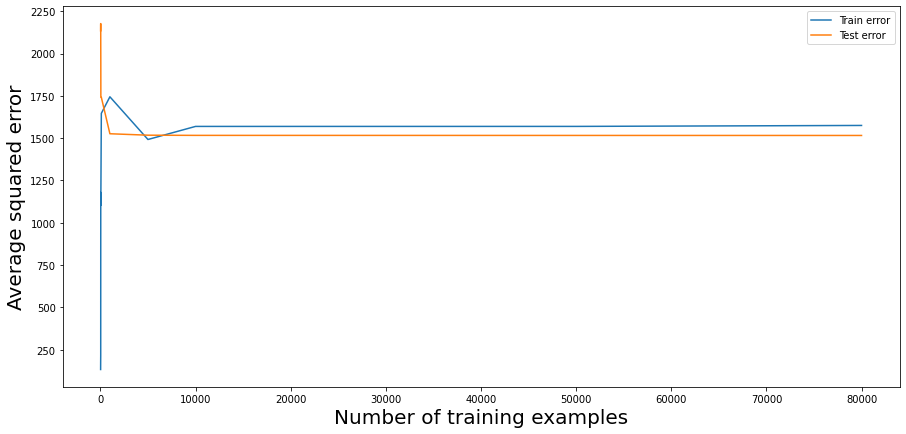

In [68]:
def plot_learning_curves(X_train, y_train, X_test, y_test):
    train_cost = []
    test_cost = []

    num_training_examples = [25, 30, 35, 40, 45, 50, 100, 1000, 5000, 10000, 50000, 80000]

    for i in num_training_examples:
        model = linear_regression.fit(X_train[:i], y_train[:i])
        train_predictions = model.predict(X_train[:i])
        test_predictions = model.predict(X_test)

        train_cost.append(linear_regression_cost_function(train_predictions, y_train[:i]))
        test_cost.append(linear_regression_cost_function(test_predictions, y_test))

    fig, axs = plt.subplots(1, figsize=(15,7))
    axs.plot(num_training_examples, train_cost, label='Train error')
    axs.plot(num_training_examples, test_cost, label='Test error')
    
    axs.set_ylabel('Average squared error', fontsize=20)
    axs.set_xlabel('Number of training examples', fontsize=20)
    axs.legend()
    plt.show()

plot_learning_curves(X_train, y_train, X_test, y_test)

As the train and test error both plataeu to a constant value as the number of training examples increases, the model is currently underfitting the data. More features should therefore be added.

# Training the model using all features
**NOTE**: All features are now polynomials of degree 1

In [98]:
X = df.drop(independent_variables, axis=1)
y = df['GHI']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
model = linear_regression.fit(X_train, y_train)
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

print_model_metrics(train_predictions, y_train, test_predictions, y_test)

Training error: 9404.511879751599
Test error: 9675.138149023916
Relative error of predictions based on test inputs w.r.t. actual test values: 0.49183502848435123


**Therefore, the relative error has decreased from around 0.75 (with a single polynomial feature) to 0.49 (with multiple degree 1 polynomial features). Adding more features has improved the model.** 

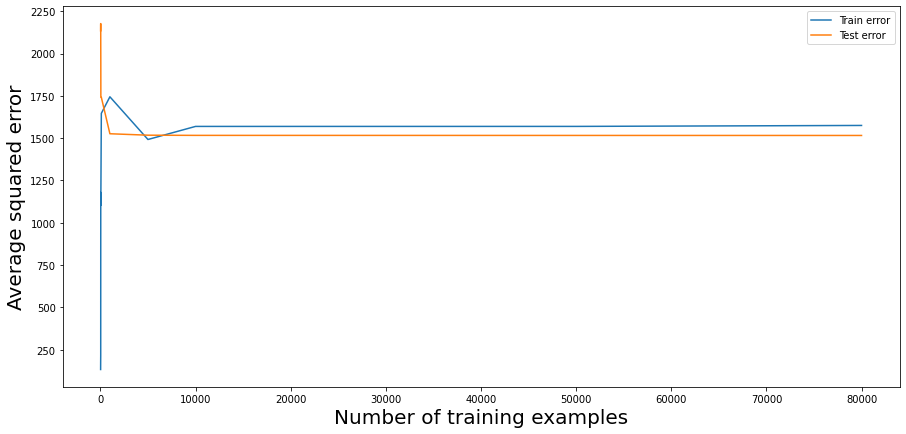

In [69]:
plot_learning_curves(X_train, y_train, X_test, y_test)

### Learning curve for multiple features
The above learning curves show that the model is still underfitting the data. Since no more features are available to be added, perhaps increasing the degree of the polynomial features will improve the model.

The below function takes a feature as input and plots the training and test errors against the degree of polynomial of the feature (while keeping the degree of other features equal to 1). This is to determine if increasing the degree of any of the features reduces the test error.

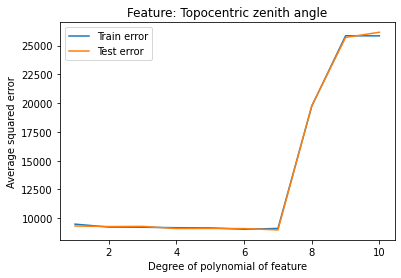

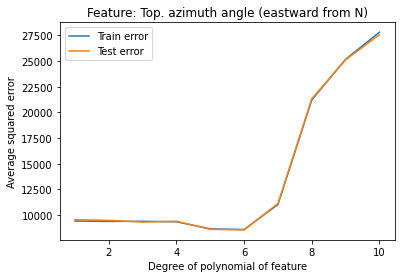

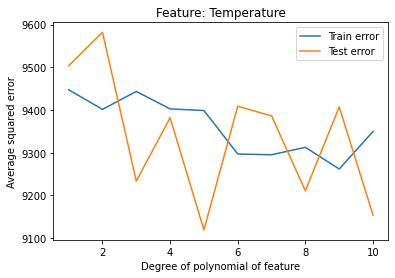

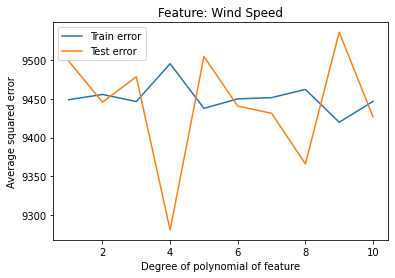

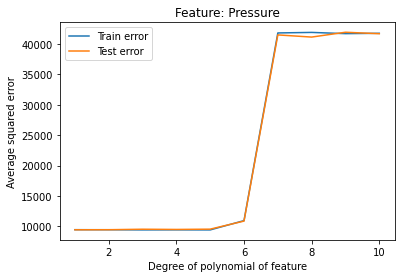

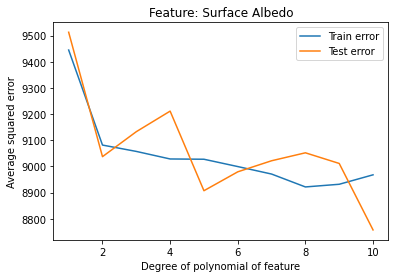

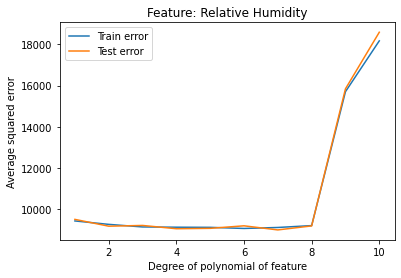

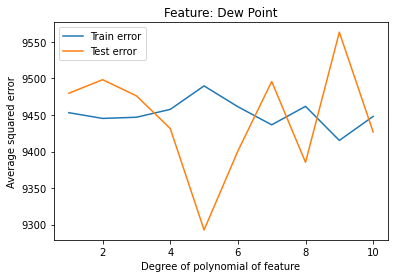

In [97]:
def plot_errors_against_degree_of_feature(df, feature, independent_variable):
    x = df[feature]
    y = df[independent_variable]

    df_copy = df.copy(deep=False)

    polynomial_degrees = [i for i in range(1, 11)]

    train_cost = []
    test_cost = []

    for degree in polynomial_degrees:
        if degree > 1:
            df_copy[f'{feature} ^ {degree}'] = x ** degree
        X = df_copy.drop(independent_variables, axis=1)
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        model = linear_regression.fit(X_train, y_train)

        train_predictions = model.predict(X_train)
        test_predictions = model.predict(X_test)

        train_cost.append(linear_regression_cost_function(train_predictions, y_train))
        test_cost.append(linear_regression_cost_function(test_predictions, y_test))

    fig, axs = plt.subplots(1)
    axs.plot(polynomial_degrees, train_cost, label='Train error')
    axs.plot(polynomial_degrees, test_cost, label='Test error')
    axs.set_ylabel('Average squared error')
    axs.set_xlabel('Degree of polynomial of feature')
    axs.set_title(f'Feature: {feature}')

    axs.legend()
    plt.show()

for variable in dependent_variables:
    plot_errors_against_degree_of_feature(df, variable, 'GHI')

The above graphs show that there is no significant reduction in test error from increasing the degree of any of the features. There is even a danger of increasing the test error when the degree of polynomial increases (see graphs for topocentric zenith angle, azimuthal angle, pressure and relative humidity)